# Evaluating LLM Prompts for Recommendation Systems

This notebook provides a comprehensive framework for testing and evaluating different prompts for LLM-based recommendation engines on Databricks. By the end of this notebook, you'll be able to:

1. Define and test multiple prompt variants
2. Evaluate prompts using several recommendation quality metrics
3. Log performance to MLflow for easy comparison
4. Visualize results to identify the best-performing prompts

## Setup
First, let's install the necessary libraries and set up our environment

In [0]:
%pip install mlflow pandas scikit-learn sentence-transformers openai

  Obtaining dependency information for mlflow from https://files.pythonhosted.org/packages/b8/f3/89dc9daf896ec5caea037dfc8cd24bcef69995aed2d30164afd69af5ec8d/mlflow-2.20.3-py3-none-any.whl.metadata
  Obtaining dependency information for mlflow-skinny==2.20.3 from https://files.pythonhosted.org/packages/39/f6/c55a49753098ae8469bb5c1b177298b65ac68f4a7334dd37b727cdcd72eb/mlflow_skinny-2.20.3-py3-none-any.whl.metadata
  Obtaining dependency information for alembic!=1.10.0,<2 from https://files.pythonhosted.org/packages/54/7e/ac0991d1745f7d755fc1cd381b3990a45b404b4d008fc75e2a983516fbfe/alembic-1.14.1-py3-none-any.whl.metadata
  Obtaining dependency information for docker<8,>=4.0.0 from https://files.pythonhosted.org/packages/e3/26/57c6fb270950d476074c087527a558ccb6f4436657314bfb6cdf484114c4/docker-7.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for graphene<4 from https://files.pythonhosted.org/packages/66/e0/61d8e98007182e6b2aca7cf65904721fb2e4bce0192272ab9cb6f69d8812/gr

In [0]:
from openai import OpenAI
import os

host_name = dbutils.notebook.entry_point.getDbutils().notebook().getContext().apiUrl().get()
os.environ["OPENAI_BASE_URL"] = host_name  + "/serving-endpoints/"
os.environ["OPENAI_API_KEY"] = dbutils.notebook.entry_point.getDbutils().notebook().getContext().apiToken().get()

In [0]:
current_username = dbutils.notebook.entry_point.getDbutils().notebook().getContext().userName().get()
current_username

'debu.sinha@databricks.com'

In [0]:
# Import required libraries
import mlflow
import time
import json
import numpy as np
import pandas as pd
# from databricks.sdk import WorkspaceClient
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
from typing import List, Dict, Tuple, Any

# Configure MLflow experiment
mlflow.set_experiment(f"/Users/{current_username}/LLM-Recommendation-Prompts")

client = OpenAI()

# Initialize sentence transformer for semantic similarity calculations
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

/databricks/python/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Sample Data

Let's create some sample user data and a catalog of items that we can use for our recommendation tasks.

In [0]:
# Sample users with their viewing/purchase history
users = [
    {
        "user_id": "user_001",
        "history": "The user has watched Inception, The Matrix, Interstellar, and Arrival. They also liked Dark on Netflix.",
        "preferred_genres": ["sci-fi", "thriller", "mystery"],
        "average_rating": 4.5
    },
    {
        "user_id": "user_002",
        "history": "The user enjoys comedies like The Hangover, Bridesmaids, and Superbad. They also watched The Office and Brooklyn Nine-Nine.",
        "preferred_genres": ["comedy", "sitcom"],
        "average_rating": 4.2
    },
    {
        "user_id": "user_003",
        "history": "The user has watched documentaries including Planet Earth, Making a Murderer, and Tiger King. They also enjoyed Mindhunter.",
        "preferred_genres": ["documentary", "true crime"],
        "average_rating": 4.7
    },
    {
        "user_id": "user_004",
        "history": "The user likes action movies such as John Wick, The Bourne Identity, and Mission Impossible. They also watched Extraction and The Old Guard.",
        "preferred_genres": ["action", "thriller"],
        "average_rating": 4.0
    }
]

# Sample catalog of items that could be recommended
catalog = [
    {"item_id": "movie_001", "title": "Blade Runner 2049", "genres": ["sci-fi", "thriller", "mystery"], "description": "A young blade runner's discovery of a long-buried secret leads him to track down former blade runner Rick Deckard, who's been missing for thirty years."},
    {"item_id": "movie_002", "title": "Gravity", "genres": ["sci-fi", "thriller", "drama"], "description": "Two astronauts work together to survive after an accident leaves them stranded in space."},
    {"item_id": "movie_003", "title": "The Martian", "genres": ["sci-fi", "adventure", "drama"], "description": "An astronaut becomes stranded on Mars after his team assume him dead, and must rely on his ingenuity to find a way to signal to Earth that he is alive."},
    {"item_id": "movie_004", "title": "Knives Out", "genres": ["mystery", "comedy", "crime"], "description": "A detective investigates the death of a patriarch of an eccentric, combative family."},
    {"item_id": "movie_005", "title": "Palm Springs", "genres": ["comedy", "romance", "fantasy"], "description": "Stuck in a time loop, two wedding guests develop a budding romance while living the same day over and over again."},
    {"item_id": "movie_006", "title": "The Social Dilemma", "genres": ["documentary", "drama"], "description": "Explores the dangerous human impact of social networking, with tech experts sounding the alarm on their own creations."},
    {"item_id": "movie_007", "title": "My Octopus Teacher", "genres": ["documentary", "nature"], "description": "A filmmaker forges an unusual friendship with an octopus living in a South African kelp forest, learning as the animal shares the mysteries of her world."},
    {"item_id": "movie_008", "title": "The Gentlemen", "genres": ["action", "crime", "comedy"], "description": "An American expat tries to sell off his highly profitable marijuana empire in London, triggering plots, schemes, bribery and blackmail in an attempt to steal his domain out from under him."},
    {"item_id": "movie_009", "title": "Tenet", "genres": ["sci-fi", "action", "thriller"], "description": "Armed with only one word, Tenet, and fighting for the survival of the entire world, a Protagonist journeys through a twilight world of international espionage on a mission that will unfold in something beyond real time."},
    {"item_id": "movie_010", "title": "Parasite", "genres": ["thriller", "drama", "comedy"], "description": "Greed and class discrimination threaten the newly formed symbiotic relationship between the wealthy Park family and the destitute Kim clan."}
]

# Convert to DataFrames for easier handling
users_df = pd.DataFrame(users)
catalog_df = pd.DataFrame(catalog)

# Display sample data
display(users_df)
display(catalog_df)

user_id,history,preferred_genres,average_rating
user_001,"The user has watched Inception, The Matrix, Interstellar, and Arrival. They also liked Dark on Netflix.","List(sci-fi, thriller, mystery)",4.5
user_002,"The user enjoys comedies like The Hangover, Bridesmaids, and Superbad. They also watched The Office and Brooklyn Nine-Nine.","List(comedy, sitcom)",4.2
user_003,"The user has watched documentaries including Planet Earth, Making a Murderer, and Tiger King. They also enjoyed Mindhunter.","List(documentary, true crime)",4.7
user_004,"The user likes action movies such as John Wick, The Bourne Identity, and Mission Impossible. They also watched Extraction and The Old Guard.","List(action, thriller)",4.0


item_id,title,genres,description
movie_001,Blade Runner 2049,"List(sci-fi, thriller, mystery)","A young blade runner's discovery of a long-buried secret leads him to track down former blade runner Rick Deckard, who's been missing for thirty years."
movie_002,Gravity,"List(sci-fi, thriller, drama)",Two astronauts work together to survive after an accident leaves them stranded in space.
movie_003,The Martian,"List(sci-fi, adventure, drama)","An astronaut becomes stranded on Mars after his team assume him dead, and must rely on his ingenuity to find a way to signal to Earth that he is alive."
movie_004,Knives Out,"List(mystery, comedy, crime)","A detective investigates the death of a patriarch of an eccentric, combative family."
movie_005,Palm Springs,"List(comedy, romance, fantasy)","Stuck in a time loop, two wedding guests develop a budding romance while living the same day over and over again."
movie_006,The Social Dilemma,"List(documentary, drama)","Explores the dangerous human impact of social networking, with tech experts sounding the alarm on their own creations."
movie_007,My Octopus Teacher,"List(documentary, nature)","A filmmaker forges an unusual friendship with an octopus living in a South African kelp forest, learning as the animal shares the mysteries of her world."
movie_008,The Gentlemen,"List(action, crime, comedy)","An American expat tries to sell off his highly profitable marijuana empire in London, triggering plots, schemes, bribery and blackmail in an attempt to steal his domain out from under him."
movie_009,Tenet,"List(sci-fi, action, thriller)","Armed with only one word, Tenet, and fighting for the survival of the entire world, a Protagonist journeys through a twilight world of international espionage on a mission that will unfold in something beyond real time."
movie_010,Parasite,"List(thriller, drama, comedy)",Greed and class discrimination threaten the newly formed symbiotic relationship between the wealthy Park family and the destitute Kim clan.


## Define Prompt Templates

Now, let's define different prompt templates that we'll evaluate. Each template represents a different approach to making recommendations.

In [0]:
# Define various prompt templates for recommendation
prompt_templates = {
    "basic": """
    You are a recommendation system. Based on the user's history:
    {user_history}
    
    Please recommend 5 items from the following catalog that the user would likely enjoy:
    {catalog_items}
    
    Format your response as a comma-separated list of titles.
    """,
    
    "detailed": """
    You are a recommendation system tasked with suggesting relevant items to users based on their viewing history.
    
    USER HISTORY:
    {user_history}
    
    PREFERRED GENRES: {preferred_genres}
    
    CATALOG:
    {catalog_items}
    
    Please analyze the user's viewing history and preferred genres, then recommend 5 items from the catalog that they would likely enjoy.
    For each recommendation, provide a brief explanation of why it matches the user's preferences.
    Format your response as a JSON list with 'title' and 'reason' keys.
    """,
    
    "structured_output": """
    You are an AI recommendation engine. Your task is to analyze user preferences and recommend items from a catalog.
    
    USER DATA:
    - Viewing History: {user_history}
    - Preferred Genres: {preferred_genres}
    - Average Rating: {avg_rating}
    
    AVAILABLE ITEMS:
    {catalog_items}
    
    INSTRUCTIONS:
    1. Analyze the user's viewing history and preferences
    2. Identify patterns in their content consumption
    3. Select 5 items from the catalog that best match their taste
    4. Rank them by relevance score (0-100)
    
    Return your recommendations in the following JSON format:
    {{
        "recommendations": [
            {{"title": "Item Title", "relevance_score": 85, "reasoning": "Brief explanation"}},
            ...
        ]
    }}
    """,
    
    "contextual": """
    You are a personalized recommendation system for a streaming platform. The user is currently browsing in the evening on a weekend and has just finished watching {last_watched}.
    
    USER PROFILE:
    {user_history}
    Genres they enjoy: {preferred_genres}
    
    AVAILABLE CONTENT:
    {catalog_items}
    
    Based on what they've just watched and their overall preferences, recommend 5 titles they might want to watch next. Consider both similarity to their just-finished content and their general taste profile.
    
    Format your response as a JSON list with 'title', 'relevance_score' (0-100), and 'watch_next_reason' keys.
    """,
    
    "few_shot": """
    You are a recommendation system. Based on viewing patterns, recommend items from a catalog.
    
    EXAMPLES:
    
    User History: "The user enjoyed The Lord of the Rings trilogy and The Hobbit. They also liked Game of Thrones."
    Catalog: ["Harry Potter series", "The Witcher", "Dune", "Star Wars", "The Crown"]
    Recommendations: 
    1. The Witcher - Fantasy series with epic world-building similar to Game of Thrones
    2. Dune - Epic sci-fi with complex world similar to Lord of the Rings
    
    User History: "The user enjoys cooking shows like Chef's Table and Salt Fat Acid Heat."
    Catalog: ["The Great British Bake Off", "Anthony Bourdain: Parts Unknown", "Queer Eye", "Formula 1: Drive to Survive"]
    Recommendations:
    1. Anthony Bourdain: Parts Unknown - Food-focused documentary series
    2. The Great British Bake Off - Competition cooking show
    
    NOW YOUR TASK:
    
    User History: {user_history}
    Preferred Genres: {preferred_genres}
    Catalog: {catalog_items}
    
    Provide 5 recommendations with brief explanations of why they match the user's taste.
    """
}

## Evaluation Metrics

Let's define functions to evaluate the quality of recommendations:

1. **Response Time**: How long it takes to generate recommendations
2. **Relevance Score**: How well recommendations match user preferences
3. **Diversity Score**: How varied the recommendations are
4. **Consistency**: Whether the model gives similar recommendations for similar inputs
5. **Formatting Compliance**: Whether the output follows the requested format

In [0]:
def prepare_catalog_text(catalog_items: List[Dict]) -> str:
    """Convert catalog items to a text representation for the prompt"""
    catalog_text = ""
    for item in catalog_items:
        catalog_text += f"- {item['title']}: {item['description']} [Genres: {', '.join(item['genres'])}]\n"
    return catalog_text

def calculate_semantic_similarity(text1: str, text2: str) -> float:
    """Calculate semantic similarity between two texts using sentence embeddings"""
    embedding1 = embedding_model.encode([text1])[0]
    embedding2 = embedding_model.encode([text2])[0]
    
    # Calculate cosine similarity
    similarity = cosine_similarity([embedding1], [embedding2])[0][0]
    return similarity

def calculate_diversity_score(recommendations: List[str], catalog_items: List[Dict]) -> float:
    """Calculate diversity score based on genre variety in recommendations"""
    # Extract recommended items from catalog
    recommended_items = [item for item in catalog_items if item['title'] in recommendations]
    
    # Get all genres from recommendations
    all_genres = []
    for item in recommended_items:
        all_genres.extend(item['genres'])
    
    # Count unique genres
    unique_genres = set(all_genres)
    
    # Calculate diversity score (normalized by total possible genres)
    all_possible_genres = set()
    for item in catalog_items:
        all_possible_genres.update(item['genres'])
    
    diversity_score = len(unique_genres) / len(all_possible_genres) if all_possible_genres else 0
    
    return diversity_score

def parse_recommendations(response: str, output_format: str) -> List[str]:
    """Extract recommended titles from LLM response based on expected format"""
    if output_format == "comma_list":
        # Parse comma-separated list
        return [title.strip() for title in response.split(',')]
    
    elif output_format in ["json", "structured"]:
        try:
            # Try to parse JSON response
            data = json.loads(response)
            if "recommendations" in data:
                return [rec["title"] for rec in data["recommendations"]]
            else:
                return [rec["title"] for rec in data]
        except json.JSONDecodeError:
            # If JSON parsing fails, try to extract titles using simpler method
            titles = []
            for line in response.split('\n'):
                if '"title":' in line:
                    title = line.split('"title":')[1].split('"')[1]
                    titles.append(title)
            return titles
    
    else:
        # Default fallback - look for numbered list or items in quotes
        titles = []
        for line in response.split('\n'):
            # Look for numbered items
            if line.strip().startswith(('1.', '2.', '3.', '4.', '5.')):
                parts = line.split('-', 1)[0].strip()
                # Remove number and potential period
                title = parts.split('.', 1)[1].strip() if '.' in parts else parts
                titles.append(title)
                
            # Look for titles in quotes
            elif '"' in line and ':' in line:
                potential_title = line.split('"')[1]
                if potential_title:
                    titles.append(potential_title)
        
        return titles if titles else [line.strip() for line in response.split('\n') if line.strip()]

def check_format_compliance(response: str, expected_format: str) -> float:
    """Check if the response follows the requested format"""
    if expected_format == "comma_list":
        # Check if response is a comma-separated list
        items = response.split(',')
        return 1.0 if len(items) > 1 else 0.0
    
    elif expected_format == "json":
        # Check if response is valid JSON
        try:
            json.loads(response)
            return 1.0
        except json.JSONDecodeError:
            return 0.0
    
    elif expected_format == "numbered_list":
        # Check if response contains numbered items
        has_numbers = any(line.strip().startswith(('1.', '2.', '3.')) for line in response.split('\n'))
        return 1.0 if has_numbers else 0.0
    
    # Default case
    return 0.5

## LLM Recommendation Function

Now, let's create a function to generate recommendations using different LLM providers and prompt templates.

In [0]:
def get_recommendations(
    user: Dict,
    catalog_items: List[Dict],
    prompt_template: str,
    model_source: str = "databricks-claude-3-5-sonnet",
    model_name: str = None,
    output_format: str = "comma_list",
    max_tokens: int = 500,
    temperature: float = 0.7
) -> Tuple[str, List[str], float]:
    """
    Generate recommendations using an LLM with the specified prompt template
    
    Args:
        user: User information including history and preferences
        catalog_items: List of items to recommend from
        prompt_template: Template string for the prompt
        model_source: 'databricks-claude-3-5-sonnet', any model deployed on PT or external model
        model_name: Specific model to use
        output_format: Expected format of the response
        max_tokens: Maximum tokens in response
        temperature: Temperature parameter for generation
        
    Returns:
        Tuple containing (raw_response, parsed_recommendations, response_time)
    """
    # Start timer
    start_time = time.time()
    
    # Get the most recently watched item for contextual prompts
    last_watched = "unknown"
    if user["history"]:
        history_text = user["history"]
        if "watched" in history_text or "liked" in history_text:
            # Simple extraction of last mentioned title - this could be improved
            all_items = history_text.replace(".", "").replace(",", "").split()
            last_watched = all_items[-1] if all_items else "unknown"
    
    # Format catalog items as text
    catalog_text = prepare_catalog_text(catalog_items)
    
    # Format preferred genres
    preferred_genres_text = ", ".join(user["preferred_genres"]) if "preferred_genres" in user else ""
    
    # Fill in the prompt template
    input_prompt = prompt_template.format(
        user_history=user["history"],
        catalog_items=catalog_text,
        preferred_genres=preferred_genres_text,
        avg_rating=user.get("average_rating", ""),
        last_watched=last_watched
    )

    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": ""
            },
            {
                "role": "user",
                "content": input_prompt
            }
            ],
            model=model_source,
            max_tokens=256
        )

    raw_response = chat_completion.choices[0].message.content.strip()
    
    # Calculate response time
    response_time = time.time() - start_time
    
    # Parse the recommendations from the response
    recommendations = parse_recommendations(raw_response, output_format)
    
    return raw_response, recommendations, response_time

## Evaluate and Log Prompt Performance

Now, let's create a function to evaluate a prompt and log its performance metrics to MLflow.

In [0]:
def evaluate_prompt_performance(
    prompt_name: str,
    prompt_template: str,
    user: Dict,
    catalog_items: List[Dict],
    model_source: str = "databricks-claude-3-5-sonnet",
    model_name: str = None,
    output_format: str = "comma_list",
    run_name: str = None
) -> Dict:
    """
    Evaluate a prompt's performance and log metrics to MLflow
    
    Args:
        prompt_name: Name of the prompt for logging
        prompt_template: The prompt template to evaluate
        user: User information
        catalog_items: Catalog items to recommend from
        model_source: LLM provider, any model deployed on PT or external model
        model_name: Specific model name
        output_format: Expected output format
        run_name: Optional name for the MLflow run
        
    Returns:
        Dictionary of metrics
    """
    # Generate a run name if not provided
    if run_name is None:
        timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
        run_name = f"{prompt_name}-{model_source}-{timestamp}"
    
    # Start MLflow run
    with mlflow.start_run(run_name=run_name) as run:
        # Log parameters
        mlflow.log_param("prompt_name", prompt_name)
        mlflow.log_param("model_source", model_source)
        mlflow.log_param("model_name", model_name)
        mlflow.log_param("user_id", user["user_id"])
        mlflow.log_param("output_format", output_format)
        
        # Log the actual prompt as an artifact
        with open("prompt.txt", "w") as f:
            f.write(prompt_template.format(
                user_history=user["history"],
                catalog_items=prepare_catalog_text(catalog_items),
                preferred_genres=", ".join(user["preferred_genres"]) if "preferred_genres" in user else "",
                avg_rating=user.get("average_rating", ""),
                last_watched="unknown"  # Simplified for logging
            ))
        mlflow.log_artifact("prompt.txt")
        
        # Generate recommendations
        raw_response, recommendations, response_time = get_recommendations(
            user=user,
            catalog_items=catalog_items,
            prompt_template=prompt_template,
            model_source=model_source,
            model_name=model_name,
            output_format=output_format
        )
        
        # Log the raw response
        with open("response.txt", "w") as f:
            f.write(raw_response)
        mlflow.log_artifact("response.txt")
        
        # Calculate metrics
        
        # 1. Response Time
        mlflow.log_metric("response_time", response_time)
        
        # 2. Relevance Score - based on similarity between user history and recommendations
        # Extract recommendation descriptions
        recommended_items = [item for item in catalog_items if item['title'] in recommendations]
        recommendation_text = " ".join([item["description"] for item in recommended_items])
        relevance_score = calculate_semantic_similarity(user["history"], recommendation_text)
        mlflow.log_metric("relevance_score", relevance_score)
        
        # 3. Genre Match Score - how well recommendations match preferred genres
        if "preferred_genres" in user and user["preferred_genres"]:
            genre_match_count = 0
            total_genres = 0
            
            for item in recommended_items:
                matching_genres = set(item["genres"]) & set(user["preferred_genres"])
                genre_match_count += len(matching_genres)
                total_genres += len(item["genres"])
            
            genre_match_score = genre_match_count / total_genres if total_genres > 0 else 0
            mlflow.log_metric("genre_match_score", genre_match_score)
        
        # 4. Diversity Score
        diversity_score = calculate_diversity_score(recommendations, catalog_items)
        mlflow.log_metric("diversity_score", diversity_score)
        
        # 5. Format Compliance
        format_compliance = check_format_compliance(raw_response, output_format)
        mlflow.log_metric("format_compliance", format_compliance)
        
        # 6. Number of recommendations
        rec_count = len(recommendations)
        mlflow.log_metric("recommendation_count", rec_count)
        
        # Calculate composite score (weighted average of metrics)
        composite_score = (
            0.3 * relevance_score + 
            0.2 * diversity_score + 
            0.2 * (genre_match_score if "preferred_genres" in user else 0.5) + 
            0.2 * format_compliance + 
            0.1 * (1.0 - min(1.0, response_time / 10.0))  # Normalize response time
        )
        mlflow.log_metric("composite_score", composite_score)
        
        # Prepare results dictionary
        metrics = {
            "run_id": run.info.run_id,
            "prompt_name": prompt_name,
            "model_source": model_source,
            "response_time": response_time,
            "relevance_score": relevance_score,
            "diversity_score": diversity_score,
            "format_compliance": format_compliance,
            "recommendation_count": rec_count,
            "composite_score": composite_score,
            "recommendations": recommendations,
            "raw_response": raw_response
        }
        
        if "preferred_genres" in user:
            metrics["genre_match_score"] = genre_match_score
            
        print(f"Evaluated prompt: {prompt_name}")
        print(f"Composite Score: {composite_score:.4f}")
        print(f"Recommendations: {', '.join(recommendations[:5])}")
        print("-" * 50)
        
        return metrics

## Run Evaluations

Now, let's evaluate all our prompts across different users and models.

In [0]:
def evaluate_all_prompts(
    users: List[Dict],
    catalog_items: List[Dict],
    prompt_templates: Dict[str, str],
    model_sources: List[str] = ["databricks-claude-3-5-sonnet", "databricks-meta-llama-3-3-70b-instruct"],
    output_formats: Dict[str, str] = None
) -> pd.DataFrame:
    """
    Evaluate all prompt templates across users and models
    
    Args:
        users: List of user information
        catalog_items: List of catalog items
        prompt_templates: Dictionary of prompt templates
        model_sources: List of model sources to evaluate
        output_formats: Dictionary mapping prompt names to expected output formats
        
    Returns:
        DataFrame with evaluation results
    """
    # Default output formats if not provided
    if output_formats is None:
        output_formats = {
            "basic": "comma_list",
            "detailed": "json",
            "structured_output": "json",
            "contextual": "json",
            "few_shot": "numbered_list"
        }
    
    # Store all results
    all_results = []
    
    # Evaluate each prompt for each user and model source
    for user in users:
        for prompt_name, prompt_template in prompt_templates.items():
            output_format = output_formats.get(prompt_name, "comma_list")
            
            for model_source in model_sources:
                # Evaluate the prompt
                result = evaluate_prompt_performance(
                    prompt_name=prompt_name,
                    prompt_template=prompt_template,
                    user=user,
                    catalog_items=catalog_items,
                    model_source=model_source,
                    output_format=output_format
                )
                
                # Add user info to result
                result["user_id"] = user["user_id"]
                
                # Append to results list
                all_results.append(result)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(all_results)
    
    return results_df

In [0]:
# Run evaluations for a subset of users and model sources
# In a real scenario, you might want to run this for all users and models
evaluation_results = evaluate_all_prompts(
    users=users[:2],  # Use the first two users for this example
    catalog_items=catalog,
    prompt_templates=prompt_templates,
    model_sources=["databricks-meta-llama-3-3-70b-instruct"]  # Use Databricks LLM for this example
)

# Display results
display(evaluation_results)

Evaluated prompt: basic
Composite Score: 0.5921
Recommendations: Blade Runner 2049, Tenet, Gravity, The Martian, Arrival is not in the catalog but based on the history
--------------------------------------------------
🏃 View run basic-databricks-meta-llama-3-3-70b-instruct-20250303-210936 at: https://e2-dogfood.staging.cloud.databricks.com/ml/experiments/2154539344713458/runs/076630e2e2234f55bd5cd64c269182ca
🧪 View experiment at: https://e2-dogfood.staging.cloud.databricks.com/ml/experiments/2154539344713458
Evaluated prompt: detailed
Composite Score: 0.4147
Recommendations: Blade Runner 2049, Tenet, Gravity, Knives Out
--------------------------------------------------
🏃 View run detailed-databricks-meta-llama-3-3-70b-instruct-20250303-210944 at: https://e2-dogfood.staging.cloud.databricks.com/ml/experiments/2154539344713458/runs/e3f5bb9f7e1e40d3b5fed633bc29abdb
🧪 View experiment at: https://e2-dogfood.staging.cloud.databricks.com/ml/experiments/2154539344713458
Evaluated prompt: str

run_id,prompt_name,model_source,response_time,relevance_score,diversity_score,format_compliance,recommendation_count,composite_score,recommendations,raw_response,genre_match_score,user_id
076630e2e2234f55bd5cd64c269182ca,basic,databricks-meta-llama-3-3-70b-instruct,4.016592264175415,0.32961425,0.5,1.0,28,0.59205168624719,"List(Blade Runner 2049, Tenet, Gravity, The Martian, Arrival is not in the catalog but based on the history, I recommend replacing it with Interstellar is also not in the catalog, so replacing it with the next best option, which would likely be a sci-fi movie, in this case, I will keep The Martian as the last recommendation and change the fourth one to a movie that the user has not seen and has a good match with their history: Blade Runner 2049, Tenet, Gravity, The Martian, is changed to Blade Runner 2049, Tenet, Gravity, The Social Dilemma does not fit well with the other 4 recommendations as the other 4 recommendations have a common theme of sci-fi, thriller, so replacing the last recommendation with the next best sci-fi, thriller option which is not in the list, so keeping the last one as The Martian, and changing the fourth one to the next best option which is a sci-fi movie: Blade Runner 2049, Tenet, Gravity, The Martian. However a better fourth option could be: Blade Runner 2049, Tenet, Gravity, The Martian -> The fourth recommendation could be the next best sci-fi)","Blade Runner 2049, Tenet, Gravity, The Martian, Arrival is not in the catalog but based on the history, I recommend replacing it with Interstellar is also not in the catalog, so replacing it with the next best option, which would likely be a sci-fi movie, in this case, I will keep The Martian as the last recommendation and change the fourth one to a movie that the user has not seen and has a good match with their history: Blade Runner 2049, Tenet, Gravity, The Martian, is changed to Blade Runner 2049, Tenet, Gravity, The Social Dilemma does not fit well with the other 4 recommendations as the other 4 recommendations have a common theme of sci-fi, thriller, so replacing the last recommendation with the next best sci-fi, thriller option which is not in the list, so keeping the last one as The Martian, and changing the fourth one to the next best option which is a sci-fi movie: Blade Runner 2049, Tenet, Gravity, The Martian. However a better fourth option could be: Blade Runner 2049, Tenet, Gravity, The Martian -> The fourth recommendation could be the next best sci-fi",0.6666666666666666,user_001
e3f5bb9f7e1e40d3b5fed633bc29abdb,detailed,databricks-meta-llama-3-3-70b-instruct,3.8830130100250244,0.34524825,0.5833333333333334,0.0,4,0.4147443455457687,"List(Blade Runner 2049, Tenet, Gravity, Knives Out)","``` [ { ""title"": ""Blade Runner 2049"", ""reason"": ""This movie matches the user's preferred genres of sci-fi, thriller, and mystery. The complex, thought-provoking storyline and futuristic setting are likely to appeal to fans of Inception, The Matrix, and Interstellar."" }, { ""title"": ""Tenet"", ""reason"": ""As a sci-fi, action, and thriller film, Tenet aligns with the user's genre preferences. The movie's complex plot, themes of time and reality, and high-stakes action sequences are likely to resonate with viewers who enjoyed Inception and Interstellar."" }, { ""title"": ""Gravity"", ""reason"": ""This sci-fi thriller features a gripping, intense storyline and stunning visual effects, which may appeal to fans of Arrival and Interstellar. The movie's focus on survival and the human condition also aligns with the user's interest in thought-provoking, mysterious stories."" }, { ""title"": ""Knives Out"", ""reason"": ""Although Knives Out is primarily a mystery film, its intricate plot and unexpected twists are likely to engage viewers who enjoy complex, puzzling storylines like those",0.6666666666666666,user_001
b2d9339423ba443a8112e962c33a3b81,structured_output,databricks-meta-llama-3-3-70b-instruct,4.044631719589233,0.047142196,0.0,0.0,

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[Trace(request_id=tr-92ccf28a4ea042cc8ae140f52ba969a4), Trace(request_id=tr-70d5bafc9a9b4df4822de972e3eae6ec), Trace(request_id=tr-73dd659d3016490c9f4e72fc2cbaf8eb), Trace(request_id=tr-27678dfe01534a9cb797204b1639a28f), Trace(request_id=tr-74f5ef859a0f4d09bf05c4e05545b2cc), Trace(request_id=tr-f513ad550da4425e9ec95af55ba305d4), Trace(request_id=tr-d84f9e46bf72492b9f2096a8cfe43ef2), Trace(request_id=tr-ad09800873264190af5a1915e1a22d4c), Trace(request_id=tr-c6a4234d581e4ff091bb9f82b8460ba2), Trace(request_id=tr-e1460c3334f241c8902c4b2230c72324)]

## Visualize Results

Let's create visualizations to compare the performance of different prompts.

In [0]:
def plot_prompt_comparison(results_df: pd.DataFrame, metric: str = "composite_score"):
    """Create a bar plot comparing prompts based on a specific metric"""
    plt.figure(figsize=(12, 6))
    
    # Group by prompt_name and calculate the mean of the specified metric
    prompt_performance = results_df.groupby('prompt_name')[metric].mean().reset_index()
    
    # Sort by the metric value
    prompt_performance = prompt_performance.sort_values(by=metric, ascending=False)
    
    # Create the bar plot
    sns.barplot(x='prompt_name', y=metric, data=prompt_performance)
    
    plt.title(f'Prompt Comparison by {metric.replace("_", " ").title()}')
    plt.xlabel('Prompt Template')
    plt.ylabel(metric.replace("_", " ").title())
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save the figure for MLflow
    plt.savefig(f"{metric}_comparison.png")
    
    return plt.gcf()

def plot_metric_radar(results_df: pd.DataFrame):
    """Create a radar plot comparing prompts across multiple metrics"""
    # Metrics to include in the radar plot
    metrics = ["relevance_score", "diversity_score", "format_compliance", 
               "genre_match_score", "recommendation_count"]
    
    # Ensure all metrics exist in the DataFrame
    metrics = [m for m in metrics if m in results_df.columns]
    
    # Group by prompt_name and calculate the mean of each metric
    prompt_metrics = results_df.groupby('prompt_name')[metrics].mean()
    
    # Normalize each metric to [0, 1] for the radar plot
    for metric in metrics:
        max_val = prompt_metrics[metric].max()
        if max_val > 0:
            prompt_metrics[metric] = prompt_metrics[metric] / max_val
    
    # Number of variables
    N = len(metrics)
    
    # What will be the angle of each axis in the plot
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Create the radar plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Add labels for each metric
    plt.xticks(angles[:-1], metrics, size=12)
    
    # Draw one axis per variable and add labels
    # for i, metric in enumerate(metrics):
    #     angle = angles[i]
    #     ax.text(angle, 1.2, metric.replace("_", " ").title(), 
    #             horizontalalignment='center', size=14)
    
    # Plot each prompt
    for prompt_name in prompt_metrics.index:
        values = prompt_metrics.loc[prompt_name].values.tolist()
        values += values[:1]  # Close the loop
        
        # Plot values
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=prompt_name)
        ax.fill(angles, values, alpha=0.1)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title("Prompt Comparison Across Metrics", size=20)
    
    # Save the figure for MLflow
    plt.savefig("radar_comparison.png")

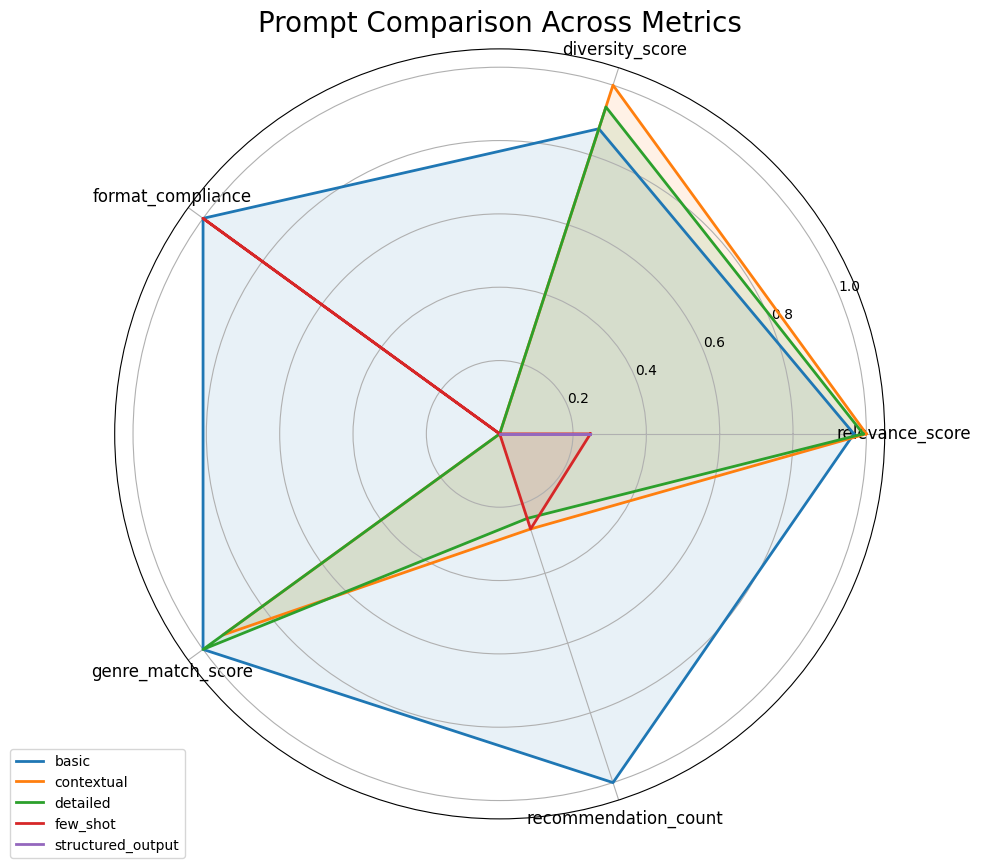

In [0]:
plot_metric_radar(evaluation_results)

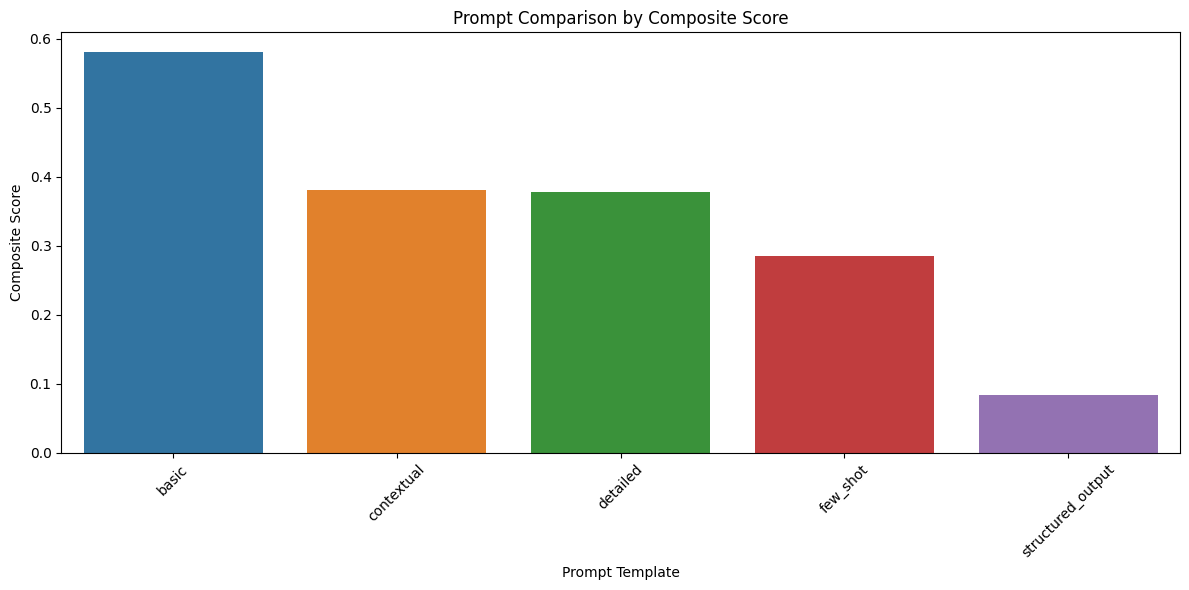

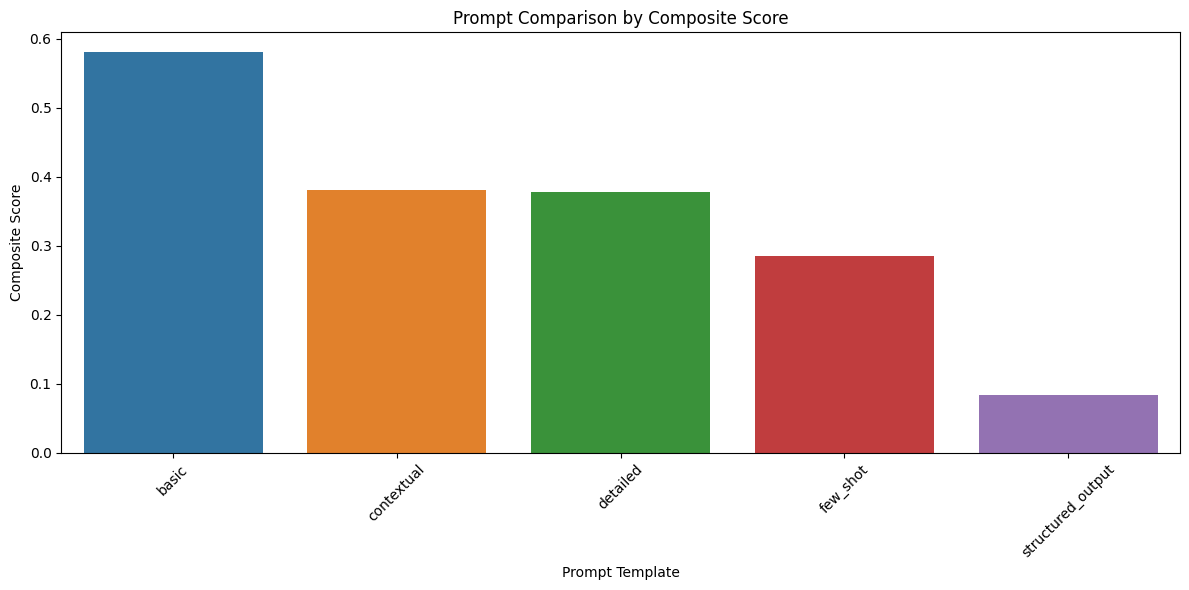

In [0]:
plot_prompt_comparison(evaluation_results)